
## Print figures of coarsened Himawari cloud mask

Link to himawari segment definitions: [here](http://www.data.jma.go.jp/mscweb/en/himawari89/cloud_service/cloud_service.html)


In [1]:
import os,sys
from glob import glob
#
import xarray as xr
from dask import compute, delayed
#from dask.distributed import Client
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
# 
from datetime import datetime
#
try:
    from satpy import Scene
except:
    print('satpy not available')
#
from utils import *

# tmp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

r2d = 180./np.pi

/Users/aponte/.miniconda3/envs/satpy-env/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
# data path
dpath = '/home/datawork-lops-osi/data/hw/mask/'
figdir = '/home1/datawork/aponte/hw/figs/'
#
dpath = './himawari/'
figdir = './figs/'

# uncompress files if necessary
filenames = []
for path, dirs, files in os.walk(dpath):
    for f in sorted(files):
        if f.split('.')[-1]=='bz2':
            print('uncompress ' +os.path.join(path,f))
            uncompress(path,f)
            filenames.append(os.path.join(path,f))
        elif f.split('.')[-1]=='DAT':
            filenames.append(os.path.join(path,f))

print('Number of files available: %d' %len(filenames))
Nfiles = len(filenames)
print('Number of files processed: %d' %len(filenames))

# extract time, band and segment numbers
time = [datetime.strptime(f.split('/')[-1].split('_B')[0], 'HS_H08_%Y%m%d_%H%M') for f in filenames]
utime = list(set(time))
band = [int(f.split('/')[-1].split('_B')[1].split('_')[0]) for f in filenames]
uband = 'B03' # manual for now
segment = [int(f.split('/')[-1].split('_S')[1][:2]) for f in filenames]


Number of files available: 40
Number of files processed: 40


In [3]:
# utils function to get files, bands for a given time
def get_ftbs(ut):
    f = [f for t, f in zip(time, filenames) if t == ut]
    b = [b for t, b in zip(time, band) if t == ut]
    s = [s for t, s in zip(time, segment) if t == ut]
    return f, ut, b, s

--- 

## Inspect one file

In [4]:
i = 0
ut = utime[i]
#f, t, b, s = filenames[i], time[i], band[i], segment[i]
f, t, b, s = get_ftbs(ut)
ds = read_hw_bin(f, t, blon=(107.,125.), blat=(-40.,-14))
print(ds)

Loads ./himawari/2017/04/01/07/HS_H08_20170401_0700_B03_FLDK_R05_S0710.DAT
Loads ./himawari/2017/04/01/07/HS_H08_20170401_0700_B03_FLDK_R05_S0810.DAT
<xarray.Dataset>
Dimensions:    (x: 3360, y: 3654)
Coordinates:
    time       datetime64[ns] 2017-04-01T07:00:00
Dimensions without coordinates: x, y
Data variables:
    B03        (y, x) float32 3.1176472 3.0588233 3.1176472 3.1176472 ...
    longitude  (y, x) float64 106.4 106.4 106.4 106.4 106.4 106.4 106.4 ...
    latitude   (y, x) float64 -14.0 -14.0 -14.0 -14.0 -14.0 -14.0 -14.0 ...


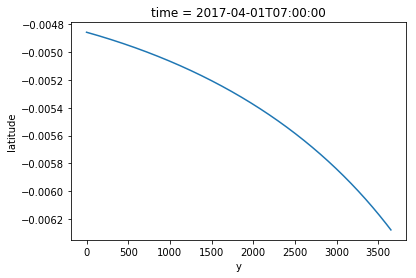

In [5]:
# check if latitude is continuous after concatenation
#ds['latitude'].isel(x=1000).plot()
ds['latitude'].isel(x=1000).diff('y').plot()

Sun zenith location: lon=75.9, lat=4.6
Himawari position: sublong=140.608583 sublat=0.002728


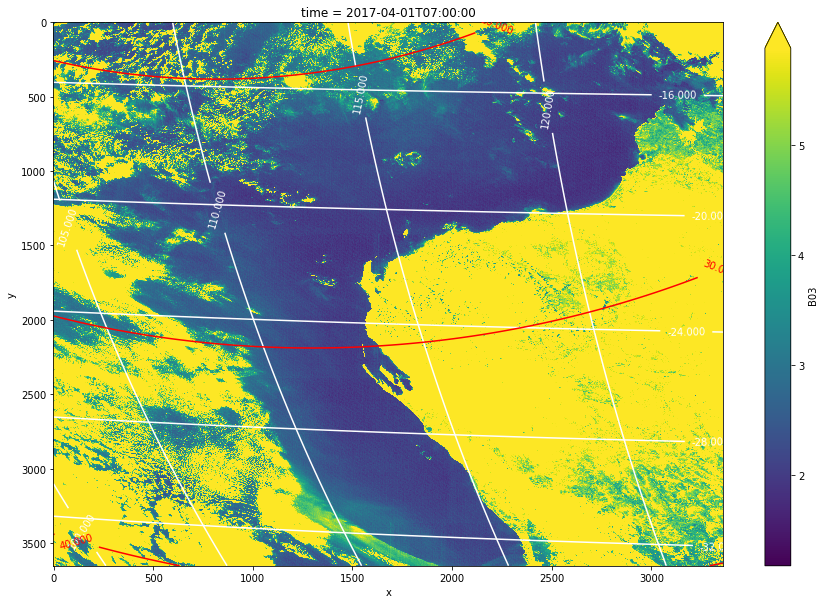

In [6]:
# computes relevant angles
angles, sun, hw = get_reflection_angles(ds['longitude'], ds['latitude'], t)

fig = plt.figure(figsize=(15,10))
dmin = ds[uband].min()
ds[uband].plot.pcolormesh(vmin=dmin,vmax=dmin*5)
im = ds['longitude'].plot.contour(colors='w',add_labels=True)
im.clabel()
im = ds['latitude'].plot.contour(colors='w')
im.clabel()

im = (angles['angle2spec']*r2d).plot.contour(levels=[0.,10.,20.,30.,40.], colors=['r'])
#im = (angles['angle2spec']*r2d).plot.contour(levels=[0.,10.,20.,30.], colors=['r'],add_labels=True)
im.clabel()

plt.gca().invert_yaxis()


In [7]:
# store file
dsm = xr.merge([ds,angles])
print(dsm)
fileout = dpath+f[0].split('/')[-1].split('_S')[0]+'.nc'
print('Stores data in '+fileout)
dsm.to_netcdf(path=fileout, format='NETCDF4')

<xarray.Dataset>
Dimensions:     (x: 3360, y: 3654)
Coordinates:
    time        datetime64[ns] 2017-04-01T07:00:00
Dimensions without coordinates: x, y
Data variables:
    B03         (y, x) float32 3.1176472 3.0588233 3.1176472 3.1176472 ...
    longitude   (y, x) float64 106.4 106.4 106.4 106.4 106.4 106.4 106.4 ...
    latitude    (y, x) float64 -14.0 -14.0 -14.0 -14.0 -14.0 -14.0 -14.0 ...
    sun_az      (y, x) float64 -1.055 -1.055 -1.055 -1.055 -1.056 -1.056 ...
    sun_alt     (y, x) float64 0.9512 0.9511 0.951 0.9509 0.9508 0.9507 ...
    angle2spec  (y, x) float64 0.3245 0.3245 0.3244 0.3244 0.3244 0.3244 ...
Stores data in ./himawari/HS_H08_20170401_0700_B03_FLDK_R05.nc


---

## loop around all files

In [ ]:
for ut in utime:
    
    f, t, b, s = get_ftbs(ut)

    # load data
    ds = read_hw_bin(f, t, blon=(108.,125.), blat=(-40.,-14))

    # computes relevant angles
    angles, sun, hw = get_reflection_angles(ds['longitude'], ds['latitude'], t)

    # plot
    if True:
        # plot
        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(111)
        dmin = ds[uband].min()
        ds[uband].plot.pcolormesh(ax=ax, vmin=dmin,vmax=dmin*2)
        im = ds['longitude'].plot.contour(ax=ax, colors='w', add_labels=True)
        im.clabel()
        im = ds['latitude'].plot.contour(ax=ax, colors='w', add_labels=True)
        im.clabel()

        im = (angles['angle2spec']*r2d).plot.contour(levels=[0.,10.,20.,30.,40.], colors=['r'])
        im.clabel()

        plt.gca().invert_yaxis()
        fig.savefig(figdir+uband+'_'+t.strftime('%Y%m%d_%H%M')+'.png', dpi=150)
        #plt.show()

    # store
    if True:
        dsm = xr.merge([ds,angles])
        fileout = dpath+f[0].split('/')[-1].split('_S')[0]+'.nc'
        print('Stores data in '+fileout)        
        dsm.to_netcdf(path=fileout, format='NETCDF4')
    